## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, learning_curve
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

from lib.sb_utils import save_file

## Load Data

In [2]:
credit_data = pd.read_csv('../data/credit_data_cleaned.csv')
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32574 entries, 0 to 32573
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   person_age                   32574 non-null  int64  
 1   person_income                32574 non-null  int64  
 2   person_emp_length            32574 non-null  float64
 3   loan_grade                   32574 non-null  int64  
 4   loan_amnt                    32574 non-null  int64  
 5   loan_int_rate                32574 non-null  float64
 6   loan_status                  32574 non-null  int64  
 7   loan_percent_income          32574 non-null  float64
 8   cb_person_default_on_file    32574 non-null  int64  
 9   cb_person_cred_hist_length   32574 non-null  int64  
 10  loan_intent_EDUCATION        32574 non-null  int64  
 11  loan_intent_HOMEIMPROVEMENT  32574 non-null  int64  
 12  loan_intent_MEDICAL          32574 non-null  int64  
 13  loan_intent_PERS

## Train/Test Split

In [3]:
# Split data into train and test splits
X_train, X_test, y_train, y_test = train_test_split(credit_data.drop(columns='loan_status'), 
                                                    credit_data.loan_status,
                                                    test_size=0.3,
                                                    random_state=67)

In [4]:
# Ensure modelable dtypes
X_train.dtypes

person_age                       int64
person_income                    int64
person_emp_length              float64
loan_grade                       int64
loan_amnt                        int64
loan_int_rate                  float64
loan_percent_income            float64
cb_person_default_on_file        int64
cb_person_cred_hist_length       int64
loan_intent_EDUCATION            int64
loan_intent_HOMEIMPROVEMENT      int64
loan_intent_MEDICAL              int64
loan_intent_PERSONAL             int64
loan_intent_VENTURE              int64
person_home_ownership_OTHER      int64
person_home_ownership_OWN        int64
person_home_ownership_RENT       int64
dtype: object

In [5]:
# Make sure no missing values
credit_data.isna().sum()

person_age                     0
person_income                  0
person_emp_length              0
loan_grade                     0
loan_amnt                      0
loan_int_rate                  0
loan_status                    0
loan_percent_income            0
cb_person_default_on_file      0
cb_person_cred_hist_length     0
loan_intent_EDUCATION          0
loan_intent_HOMEIMPROVEMENT    0
loan_intent_MEDICAL            0
loan_intent_PERSONAL           0
loan_intent_VENTURE            0
person_home_ownership_OTHER    0
person_home_ownership_OWN      0
person_home_ownership_RENT     0
dtype: int64

## GridSearch - Logistic Regression

In [6]:
# Linear regression pipeline
lr_pipe = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression),
    LogisticRegression()
)

In [7]:
# Different hyperparameters to test
k = np.arange(1, len(X_train.columns)+1)
param_grid = {'selectkbest__k': k}

In [8]:
# Grid search for hyperparameters
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=param_grid, cv=5, n_jobs=-1)

In [9]:
# Fit to training data
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x1752b47c0>)),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])})

In [10]:
# Print the best parameters
lr_grid_cv.best_params_

{'selectkbest__k': np.int64(15)}

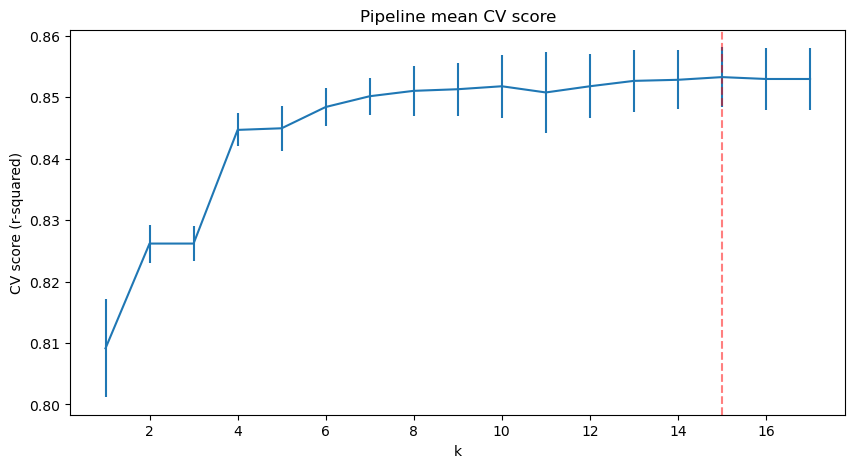

In [11]:
# Display performance at different number of features (k)
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score');

In [12]:
# Top features according to model
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_grid_cv.best_estimator_.named_steps.logisticregression.coef_.flatten()
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=True)

loan_amnt                     -0.650280
person_home_ownership_OWN     -0.436361
loan_intent_VENTURE           -0.405077
loan_intent_EDUCATION         -0.327865
loan_intent_PERSONAL          -0.211599
loan_intent_MEDICAL           -0.068010
cb_person_default_on_file     -0.037149
person_emp_length             -0.035971
loan_int_rate                 -0.017146
person_age                    -0.009100
loan_intent_HOMEIMPROVEMENT    0.011535
person_income                  0.091675
person_home_ownership_RENT     0.367403
loan_grade                     1.088776
loan_percent_income            1.380838
dtype: float64

## RandomizedSearch - Random Forest

In [13]:
# Random forest pipeline
rf_pipe = make_pipeline(
    RandomForestClassifier(random_state=47)
)

In [14]:
# Different hyperparamters to test
k = np.arange(1, len(X_train.columns)+1)
param_dist = {
    'randomforestclassifier__n_estimators': randint(50, 300),
    'randomforestclassifier__max_depth': randint(3, 20),
    'randomforestclassifier__min_samples_split': randint(2, 20),
    'randomforestclassifier__min_samples_leaf': randint(1, 10),
    'randomforestclassifier__bootstrap': [True, False]
}

In [15]:
# Randomized search for hyperparameters
rf_grid_cv = RandomizedSearchCV(rf_pipe, param_distributions=param_dist, cv=5, n_jobs=-1)

In [16]:
# Fit to trianing data
rf_grid_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('randomforestclassifier',
                                              RandomForestClassifier(random_state=47))]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__bootstrap': [True,
                                                                              False],
                                        'randomforestclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x175353b10>,
                                        'randomforestclassifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17536ce90>,
                                        'randomforestclassifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1753539d0>,
                                        'randomforestclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x175356510>})

In [17]:
# Print the best parameters
rf_grid_cv.best_params_

{'randomforestclassifier__bootstrap': False,
 'randomforestclassifier__max_depth': 19,
 'randomforestclassifier__min_samples_leaf': 3,
 'randomforestclassifier__min_samples_split': 3,
 'randomforestclassifier__n_estimators': 241}

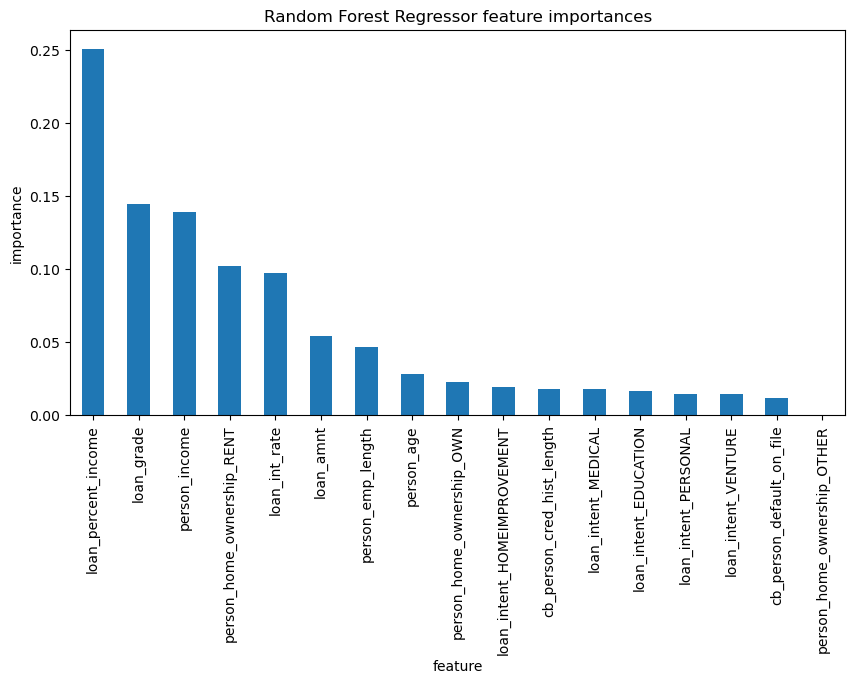

In [18]:
# See what features the Random Forest model deems most important
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestclassifier.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('feature')
plt.ylabel('importance')
plt.title('Random Forest Regressor feature importances');


The model reveals `loan_percent_income`, `loan_grade`, and `person_income` are the most important features to predicting defaulting.

## Final Model Selection

In [19]:
# Compare scores of both models
models = {"Logistic Regression": lr_grid_cv.best_estimator_, "Random Forest": rf_grid_cv.best_estimator_}
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print("Model:", name)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))
    print("\n")

Model: Logistic Regression
Accuracy: 0.8491763020566868
Precision: 0.7311475409836066
Recall: 0.5117026158788435
F1 Score: 0.6020518358531317
ROC-AUC: 0.8671831932240897


Model: Random Forest
Accuracy: 0.9348204236160851
Precision: 0.9706959706959707
Recall: 0.7296925195043598
F1 Score: 0.8331150117893634
ROC-AUC: 0.9370944284291007




The random forest model performs significantly better across all metrics.

## Data Quantity Evaluation

In [20]:
# Different fractions of splits tested
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(lr_pipe, X_train, y_train, train_sizes=fractions)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

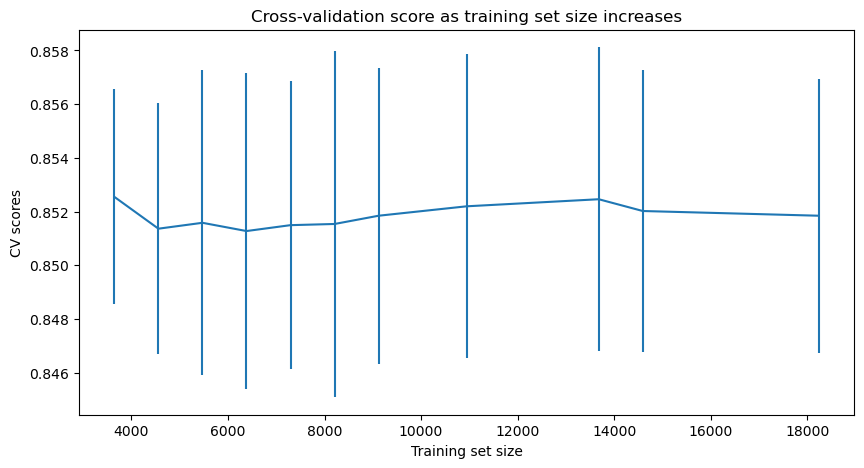

In [21]:
# scores at different train/test splits
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

There seems to be more than enough data.

## Saving Best Model

In [22]:
# Saving the best model to variable "best_model"
best_model = rf_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [23]:
save_file(best_model, 'credit_model.pkl', '../models')

A file already exists with this name.


Please re-run this cell with a new filename.


BEST MODEL
model: Random Forest

HYPERPARAMETERS
bootstrap = True
max_depth = 12
min_samples_leaf = 9
min_samples_split = 6
n_estimators = 179
n_features = 15

PERFORMANCE
Accuracy = 0.931
Precision = 0.965
Recall = 0.716
F1 Score = 0.822
ROC-AUC = 0.929